In [89]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.image_classification.models.resnext import ResNeXt
from torchvision import transforms
from torchvision.datasets import EuroSAT
from tqdm import tqdm

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 16

In [64]:
artifact_path = Path("../../artifacts/resnext")
data_path = Path("../../data/euroSAT")

In [7]:
device = torch.device("cuda:0")

# data

In [9]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [18]:
dataset = EuroSAT(
    data_path.as_posix(),
    transform=preprocess,
    download=True,
)

In [19]:
train_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [20]:
num_class = len(dataset.classes)

In [21]:
dataset.classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [57]:
len(dataset)

27000

River


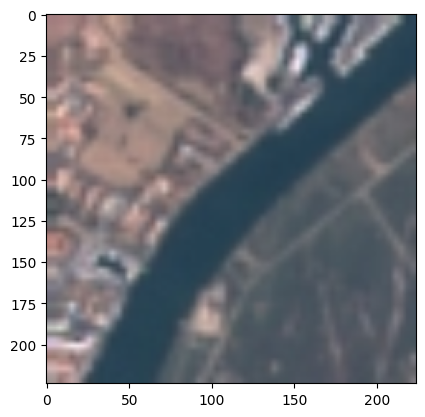

In [53]:
import random
demo_img, demo_label = dataset[random.randint(0, len(dataset))]
print(dataset.classes[demo_label])
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [54]:
model = ResNeXt(output_size=num_class, key=50).to(device)

In [55]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
ResNeXt                                            --
├─Sequential: 1-1                                  --
│    └─ConvBnRelu: 2-1                             --
│    │    └─Conv2d: 3-1                            9,408
│    │    └─BatchNorm2d: 3-2                       128
│    │    └─ReLU: 3-3                              --
│    └─MaxPool2d: 2-2                              --
├─Sequential: 1-2                                  --
│    └─ResBlock: 2-3                               --
│    │    └─BottleNeck: 3-4                        46,592
│    │    └─ConvBnRelu: 3-5                        16,896
│    └─ResBlock: 2-4                               --
│    │    └─BottleNeck: 3-6                        71,168
│    │    └─Identity: 3-7                          --
│    └─ResBlock: 2-5                               --
│    │    └─BottleNeck: 3-8                        71,168
│    │    └─Identity: 3-9                          --
├─S

# training

In [56]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), weight_decay=1e-5)

In [58]:
epoches = 10
acc_iters = 64 // BATCH_SIZE

In [59]:
training_loss = []

model.train()
for e in range(epoches):
    running_loss = 0.0
    acc_iter = 0
    optim.zero_grad()
    
    for img, label in tqdm(train_loader):
        img = img.to(device)
        label = label.to(device)
        
        output = model(img)
        loss = criterion(output,label)
        loss /= acc_iters
        loss.backward()

        if acc_iter % acc_iters == 0:
            optim.step()
            optim.zero_grad()
            
        running_loss += loss.item()
        acc_iter += 1

    training_loss.append(running_loss/len(dataset))
    
    print(f'epoch {e+1}: {training_loss[e]}')

  0%|          | 0/1687 [00:00<?, ?it/s]

100%|██████████| 1687/1687 [07:37<00:00,  3.69it/s]


epoch 1: 0.01617806220137411


100%|██████████| 1687/1687 [05:12<00:00,  5.40it/s]


epoch 2: 0.0084198477992581


100%|██████████| 1687/1687 [05:16<00:00,  5.33it/s]


epoch 3: 0.005765406118050494


100%|██████████| 1687/1687 [05:10<00:00,  5.42it/s]


epoch 4: 0.004300880869790153


100%|██████████| 1687/1687 [05:08<00:00,  5.46it/s]


epoch 5: 0.0035618745703293285


100%|██████████| 1687/1687 [05:07<00:00,  5.48it/s]


epoch 6: 0.003035534099380365


100%|██████████| 1687/1687 [05:02<00:00,  5.58it/s]


epoch 7: 0.0026473794794076603


100%|██████████| 1687/1687 [05:03<00:00,  5.56it/s]


epoch 8: 0.0024371889563432583


100%|██████████| 1687/1687 [05:05<00:00,  5.53it/s]


epoch 9: 0.0023448507557763216


100%|██████████| 1687/1687 [05:18<00:00,  5.30it/s]

epoch 10: 0.002069842498182509


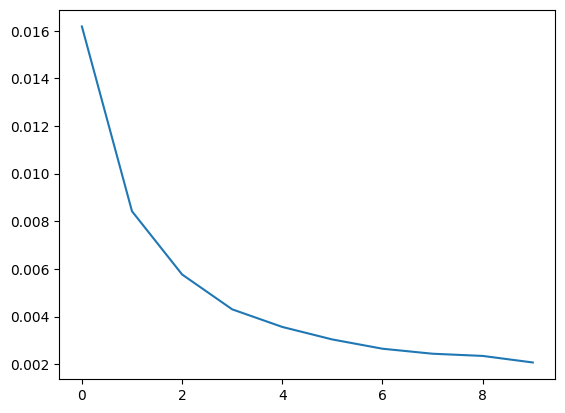

In [61]:
plt.plot(training_loss)

# inference

In [75]:
test_preprocess = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [76]:
test_dataset = EuroSAT(
    data_path.as_posix(),
    transform=test_preprocess,
    download=True,
)

In [77]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [78]:
evaluator = ClassificationEvaluator(num_class, device)

In [80]:
confusion_matrix = evaluator.run(test_loader, model)

[[2832    7    6   12    0   38   63    0   20   22]
 [   0 2992    6    0    0    0    0    0    1    1]
 [  24   18 2732    3    3    6  207    2    1    4]
 [   4    0    6 2381   49    0    6   28   25    1]
 [   0    0    2    3 2475    0    4   16    0    0]
 [   2   33   61    1    0 1865   31    0    3    4]
 [  33    0   17    2    5    1 2440    0    2    0]
 [   0    0   47    0   22    0    8 2923    0    0]
 [  14    1   13   21    5   13    4    0 2425    4]
 [   1   22    3    0    0    2    0    0   12 2960]]


In [81]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(test_dataset.classes, per_class_acc)

AnnualCrop: 0.944
Forest    : 0.9973333333333333
HerbaceousVegetation: 0.9106666666666666
Highway   : 0.9524
Industrial: 0.99
Pasture   : 0.9325
PermanentCrop: 0.976
Residential: 0.9743333333333334
River     : 0.97
SeaLake   : 0.9866666666666667


In [82]:
per_class_acc.mean()

0.9633900000000001

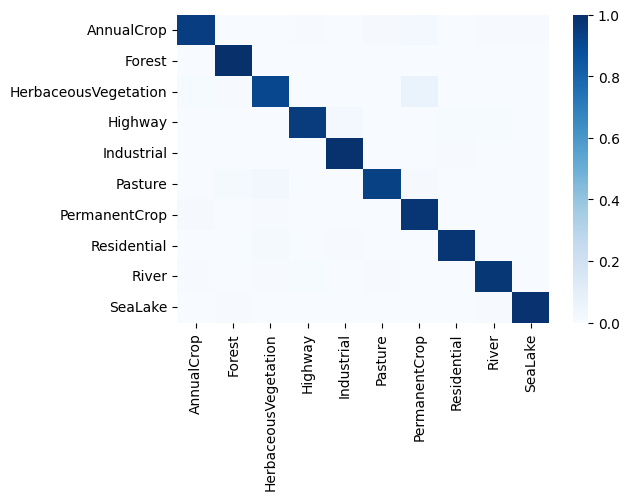

In [83]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    test_dataset.classes,
    "Blues",
    annot=False,
    figsize=(6, 4),
)

In [84]:
model_path = artifact_path / 'resnext.pth'

In [85]:
torch.save(model.state_dict(), model_path)

In [86]:
get_file_size(model_path)

88.11082649230957

In [88]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>